<a href="https://colab.research.google.com/github/DanielGCG/PS-2025.1-XRay/blob/main/Progresso/%23XRay_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Passos para realizar uma análise exploratória de dados

- Limpeza de outliers
- Análise da utilidade de colunas para o modelo final e preenchimento de colunas com nulos.

## Vamos tentar nos livrar dos pontos fora da curva

- O que são esses pontos fora da curva?

São dados que não fazem sentido, devido ao seu contexto. Por exemplo, um time com 30 gols. É praticamente impossível de acontecer, casos extremos -apesar de poucos- podem causar grande impacto em nosso modelo. Eles tornam a análise enviesada, por isso devemos tratá-los.

### Como limpar os pontos fora da curva?

Podemos fazer uma análise artesanal de cada coluna, seguindo o senso do contexto, que nesse caso é o futebol. Além disso, também podemos usar alguns métodos como o IQR.

- Análise artesanal (como deve se comportar as colunas):
    - chutes a gol < 10
    - faltas < 40
    - substituições < 6
    - posse de bola 1 + posse de bola 2 igual a 100
    - posse de bola 1/2 < 99% e posse de bola 1/2 > 1%
    - cartões amarelos < 8
    - cartões vermelho < 3
- Método IQR

O IQR é baseado em quartis, que dividem um conjunto de dados ordenados em quatro partes iguais:

Q1 (primeiro quartil): 25% dos dados estão abaixo desse valor.

Q3 (terceiro quartil): 75% dos dados estão abaixo desse valor.

IQR (Intervalo Interquartil): IQR=Q3−Q1IQR=Q3−Q1

Esse intervalo representa o “miolo” dos dados, ou seja, onde estão os valores mais comuns (entre 25% e 75%).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega o CSV
df_original = pd.read_csv('entrada.csv')
df = df_original.copy()

# Cabeçalho da tabela
print(f"{'Coluna':<25} {'Qtd Outliers':<15} {'Média Outliers':<20} {'% Removido':<12}")
print('-' * 72)

# Define colunas com tratamento especial
colunas_gols = ['Gols 1', 'Gols 2']
colunas_faltas = ['Faltas 1', 'Faltas 2']
colunas_subs = ['Substituições 1', 'Substituições 2']
colunas_posse = ['Posse 1(%)', 'Posse 2(%)']
colunas_cartoes_amarelos = ['Cartões amarelos 1', 'Cartões amarelos 2']
colunas_cartoes_vermelhos = ['Cartões vermelhos 1', 'Cartões vermelhos 2']

# Função padrão com IQR ajustado
def identificar_outliers_iqr(coluna):
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 2.7 * IQR    # Ajustado para apenas detectar outliers extremos
    limite_superior = Q3 + 2.7 * IQR    # Ajustado para apenas detectar outliers extremos
    return coluna[(coluna < limite_inferior) | (coluna > limite_superior)]

# Tratamento especial

df = df[(df['Posse 1(%)'] + df['Posse 2(%)']).round(1) == 100] # Remove linhas onde a soma de posse não é ~100%


def identificar_outliers_personalizado(coluna, nome):
    if nome in colunas_gols:
        return coluna[coluna >= 10]
    elif nome in colunas_faltas:
        return coluna[coluna >= 40]
    elif nome in colunas_subs:
        return coluna[coluna >= 6]
    elif nome in colunas_cartoes_amarelos:
        return coluna[coluna > 8]
    elif nome in colunas_cartoes_vermelhos:
        return coluna[coluna > 3]
    else:
        return identificar_outliers_iqr(coluna)

# Itera por cada coluna numérica
for coluna in df.select_dtypes(include=['int64', 'float64']).columns:
    serie = df[coluna]
    outliers = identificar_outliers_personalizado(serie, coluna)
    qtd_outliers = len(outliers)
    media_outliers = outliers.mean() if not outliers.empty else 0
    perc_outliers = (qtd_outliers / len(df_original)) * 100

    # Remove os outliers
    df = df[~df[coluna].isin(outliers)]

    # Imprime linha da tabela
    print(f"{coluna:<25} {qtd_outliers:<15} {media_outliers:<20.2f} {perc_outliers:<.2f}%")

# Salva o CSV limpo
df.to_csv('saida_sem_outliers.csv', index=False)
print("\nArquivo limpo salvo como 'saida_sem_outliers.csv'")

Coluna                    Qtd Outliers    Média Outliers       % Removido  
------------------------------------------------------------------------
Chutes a gol 1            79              17.16                0.29%
Chutes a gol 2            42              16.90                0.15%
Impedimentos 1            118             9.86                 0.43%
Impedimentos 2            76              9.71                 0.27%
Escanteios 1              24              18.71                0.09%
Escanteios 2              44              15.98                0.16%
Chutes fora 1             46              20.43                0.17%
Chutes fora 2             27              46.15                0.10%
Faltas 1                  1               46.00                0.00%
Faltas 2                  2               105.00               0.01%
Cartões amarelos 1        2               10.00                0.01%
Cartões amarelos 2        6               9.00                 0.02%
Cartões vermelhos 1    

### O que concluímos?

Podemos ver que algumas bizarrices foram eliminadas, como por exemplo 2 linhas em que a média das faltas foi 105, não é realista. Vale ressaltar que perdemos pouquíssima informação, não passando de 0.5% os índices de remoção de linhas. Com esses ajustes, podemos prosseguir para a análise individual das colunas.

## Vamos analisar as colunas individualmente

Primeiramente, devemos considerar o objetivo da análise, que no caso é criar um modelo de previsão de resultado de jogo de futebol. Para isso, precisamos verificar o quão relevante as colunas que vamos investigar são para o número de gols. Escolhemos 'gols' como alvo, pois a diferença de número de gols dos times que indica vitória, derrota e empate.


Nesse documento, vamos focar na análise das seguintes colunas:
- Tiros de meta
- Substituições
- Contra-ataques

### Tiros de meta

Primeiramente, vamos dar uma olhada na composição dos dados não nulos que temos disponíveis. Da forma em que está, temos 12910 dados nulos (52.68%) e 11595 dados não nulos (47.32%). Dada essa grande ausência de dados, precisamos usar métodos que aproveitem da correlação com outras colunas para preenchermos os dados faltantes com uso dos vizinhos.

In [ ]:
df = pd.read_csv("saida_sem_outliers.csv")

for col in ['Tiro de meta 1', 'Tiro de meta 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Tiro de meta 1
nulos     : 12910 (52.68%)
não nulos : 11595 (47.32%)
----------------------------------------
Tiro de meta 2
nulos     : 12910 (52.68%)
não nulos : 11595 (47.32%)
----------------------------------------


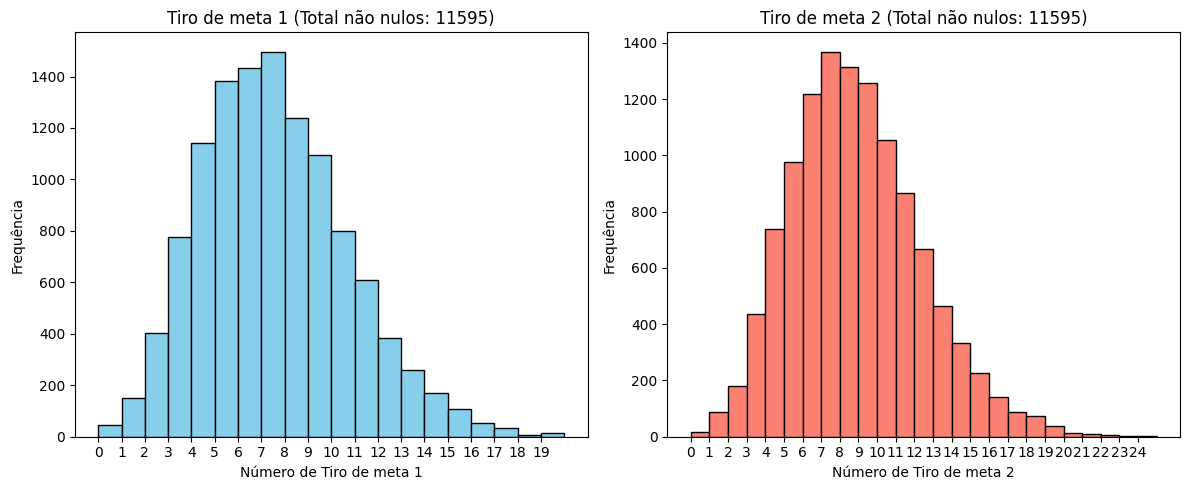

Tiro de meta 1 - média: 7.078137128072445
Tiro de meta 2 - média: 8.3742992669254
Tiro de meta 1 - mediana: 7.0
Tiro de meta 2 - mediana: 8.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers.csv', 'Tiro de meta 1', 'Tiro de meta 2')

Para resolver esse problema, vamos optar pelo método KNN (K-Nearest Neighbors). Esse algorítmo procura os vizinhos próximos e usamos a sua distância para prever um valor que seria válido de acordo com as semelhanças dos vizinhos. Se fossemos levar para um contexto mais simples, esse algorítmo copia o trabalho das colunas vizinhas semelhantes e tentar gerar sua própria versão com oque analisou. Para escolhermos quais colunas nos interessam para usar no KNN devemos olhar para o gráfico abaixo:

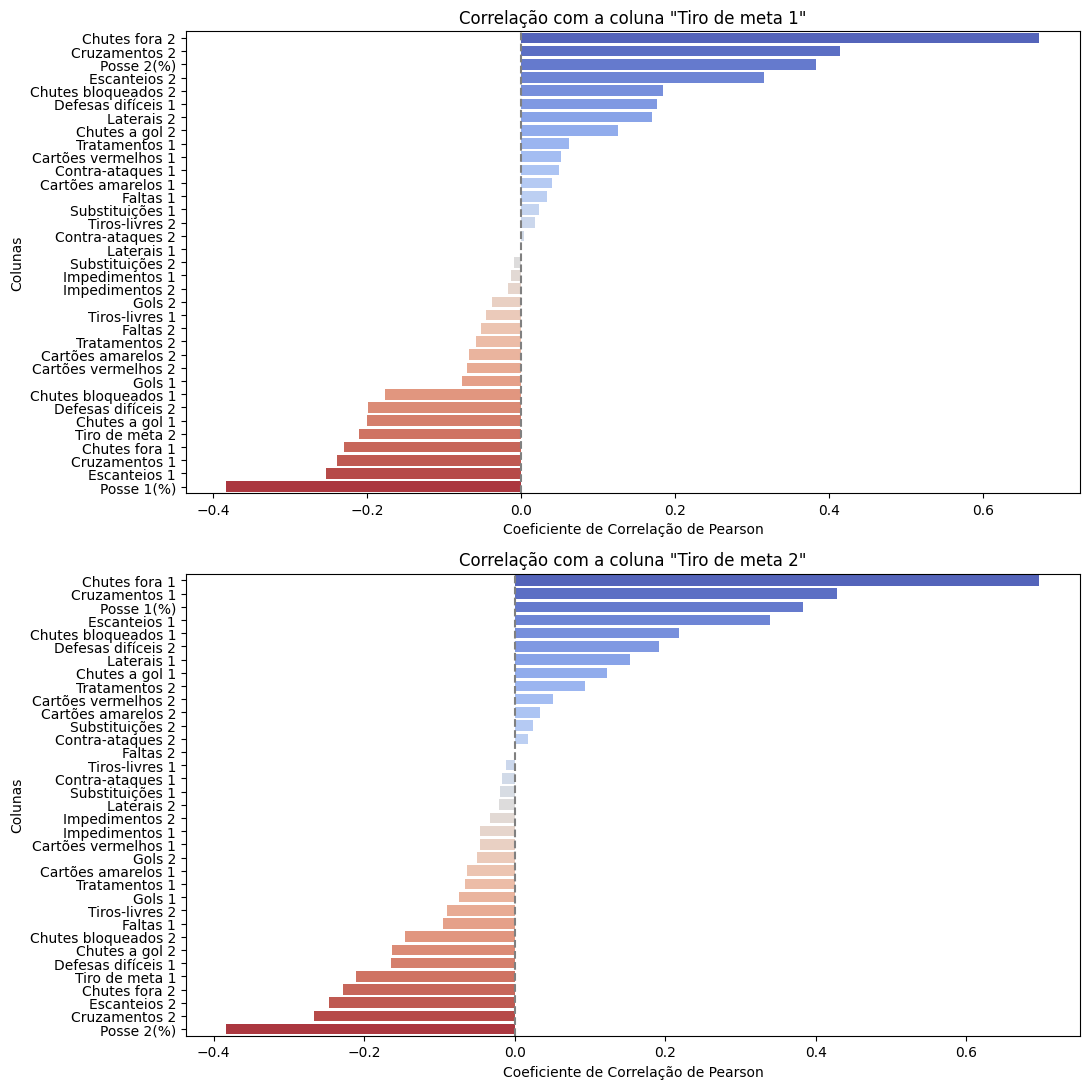

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def grafico_correlacoes(csv_path, colunas_alvo):
    # Lê o CSV
    df = pd.read_csv(csv_path)

    # Garante que só colunas numéricas sejam usadas na correlação
    df_numerico = df.select_dtypes(include='number')

    # Verifica se todas as colunas alvo existem no dataset
    for coluna in colunas_alvo:
        if coluna not in df_numerico.columns:
            raise ValueError(f"A coluna '{coluna}' não é numérica ou não está no dataset.")

    # Número de subgráficos (linhas)
    num_colunas = len(colunas_alvo)

    plt.figure(figsize=(11, 11))

    for i, coluna_alvo in enumerate(colunas_alvo, start=1):
        # Calcula a correlação da coluna alvo com todas as outras
        correlacoes = df_numerico.corr()[coluna_alvo].drop(labels=[coluna_alvo])

        # Ordena por valor da correlação
        correlacoes_ordenadas = correlacoes.sort_values(ascending=False)

        # Cria subgráfico
        plt.subplot(num_colunas, 1, i)  # Divide o espaço em linhas
        sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm', orient='h')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.title(f'Correlação com a coluna "{coluna_alvo}"')
        plt.xlabel('Coeficiente de Correlação de Pearson')
        plt.ylabel('Colunas')

    plt.tight_layout()
    plt.show()

grafico_correlacoes('saida_sem_outliers.csv', ['Tiro de meta 1', 'Tiro de meta 2'])

As colunas candidatas para nosso método KNN são as de maior correlação, elas são:

- Chutes fora ✅
- Cruzamento ❌
- Posse ✅
- Escanteios ✅

Agora vamos verificar se essas candidatas são válidas ou não.

In [ ]:
df = pd.read_csv("saida_sem_outliers.csv")

for col in ['Chutes fora 1', 'Chutes fora 2', 'Cruzamentos 1', 'Cruzamentos 2', 'Posse 1(%)', 'Posse 2(%)', 'Escanteios 1', 'Escanteios 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Chutes fora 1
nulos     : 6 (0.02%)
não nulos : 24499 (99.98%)
----------------------------------------
Chutes fora 2
nulos     : 6 (0.02%)
não nulos : 24499 (99.98%)
----------------------------------------
Cruzamentos 1
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Cruzamentos 2
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Posse 1(%)
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Posse 2(%)
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Escanteios 1
nulos     : 9 (0.04%)
não nulos : 24496 (99.96%)
----------------------------------------
Escanteios 2
nulos     : 9 (0.04%)
não nulos : 24496 (99.96%)
----------------------------------------


✅ Começamos por 'Chutes fora', o tiro de meta geralmente advém de um chute fora feito pelo time adversário. Isso ficou bem claro no gráfico, praticamente 0.7 de coeficiente de correlação. E além disso, a quantidade de dados não nulos de 'Chutes fora' é infima, tornando-se assim perfeita candidata.

❌ 'Cruzamentos', por outro lado, apenas analisando a quantidade de dados nulos, eles são maioria (65.21%), tornando praticamente inútil o seu uso.

✅ 'Posse' é forte candidata pelo coeficiente de correlação alto (de quase 0.4) e além disso, 100% dos seus dados são não nulos!

✅ 'Escanteios' tem poucos dados nulos, que é um primeiro bom sinal. Além disso, possui uma correlação considerável de entre 0.2 e 0.3 de coeficiente de correlação. Tornando-se assim, uma boa coluna candidata também.

In [ ]:
def preencher_com_knn(caminho_entrada, caminho_saida, coluna_alvo, colunas_auxiliares, n_vizinhos=3):
    # Carrega os dados
    df = pd.read_csv(caminho_entrada)

    # Conta nulos antes
    nulos_antes = df[coluna_alvo].isnull().sum()

    # Remove linhas com nulos nas colunas auxiliares
    df_aux = df[colunas_auxiliares + [coluna_alvo]].dropna(subset=colunas_auxiliares)

    # Divide entre linhas com e sem alvo
    df_treino = df_aux[df_aux[coluna_alvo].notnull()]
    df_predicao = df_aux[df_aux[coluna_alvo].isnull()]

    if df_predicao.empty:
        print("[INFO] Nenhum valor nulo para preencher na coluna alvo.")
        df.to_csv(caminho_saida, index=False)
        return

    # Prepara treino
    X_train = df_treino[colunas_auxiliares]
    y_train = df_treino[coluna_alvo]

    # Prepara predição
    X_pred = df_predicao[colunas_auxiliares]

    # Modelo KNN
    model = KNeighborsRegressor(n_neighbors=n_vizinhos)
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_pred)

    # Preenche os nulos no dataframe original
    df.loc[df[coluna_alvo].isnull() & df[colunas_auxiliares].notnull().all(axis=1), coluna_alvo] = y_pred

    # Pós-preenchimento
    nulos_depois = df[coluna_alvo].isnull().sum()
    nulos_preenchidos = nulos_antes - nulos_depois
    media_preenchida = y_pred.mean()

    # Salva resultado
    df.to_csv(caminho_saida, index=False)

    # Relatório
    print(f"[RELATÓRIO - {coluna_alvo}]")
    print(f"Total de nulos antes:    {nulos_antes}")
    print(f"Nulos preenchidos:       {nulos_preenchidos}")
    print(f"Nulos restantes:         {nulos_depois}")
    print(f"Média dos valores previstos: {media_preenchida:.2f}\n")

preencher_com_knn('saida_sem_outliers.csv', 'saida_sem_outliers_preenchido.csv', 'Tiro de meta 1', ['Chutes fora 2', 'Posse 2(%)', 'Escanteios 2'])
preencher_com_knn('saida_sem_outliers_preenchido.csv', 'saida_sem_outliers_preenchido.csv', 'Tiro de meta 2', ['Chutes fora 1', 'Posse 1(%)', 'Escanteios 1'])

[RELATÓRIO - Tiro de meta 1]
Total de nulos antes:    12910
Nulos preenchidos:       12900
Nulos restantes:         10
Média dos valores previstos: 7.88

[RELATÓRIO - Tiro de meta 2]
Total de nulos antes:    12910
Nulos preenchidos:       12900
Nulos restantes:         10
Média dos valores previstos: 9.31



Agora nos resta plotar o novo resultado que obtivemos!

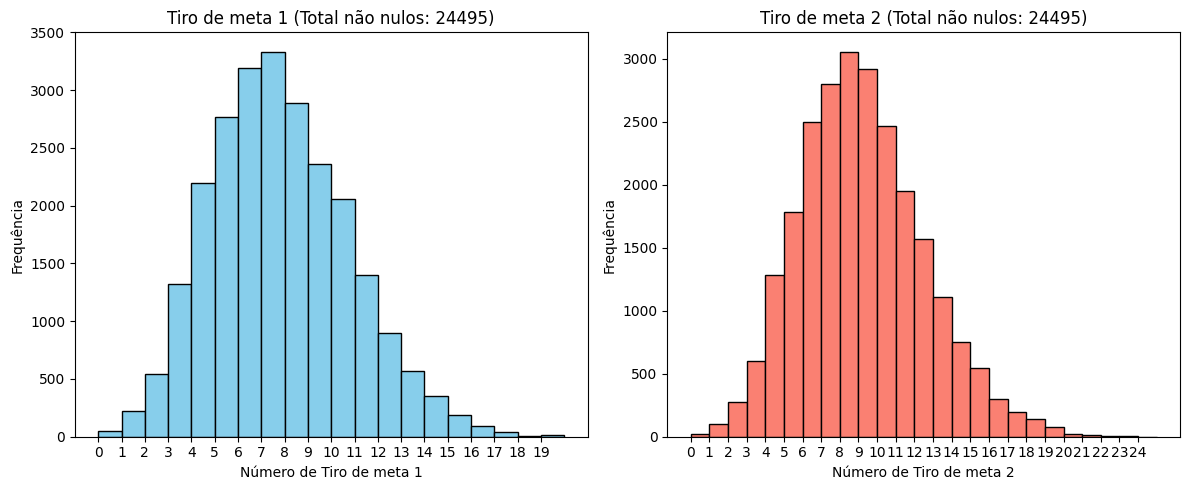

Tiro de meta 1 - média: 7.502524324692113
Tiro de meta 2 - média: 8.868136354358034
Tiro de meta 1 - mediana: 7.0
Tiro de meta 2 - mediana: 8.666666666666666


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers_preenchido.csv', 'Tiro de meta 1', 'Tiro de meta 2')

### Substituições

Para começar, vamos verificar quantos dados possuímos: 15480 nulos (63.17%) e 9025 não nulos (36.83%). Vamos verificar se a coluna é de fato interessante para nosso modelo. Vamos verificar a correlação atual de 'Substituições' com 'gols': a maior correlação é de 0.03. A correlação entre 'Gols' e 'Substituições' é tão baixa que podemos ignorar essa coluna, pois as mudanças nela fazem quase nenhuma diferença nos resultados de gols. Vejamos também o histograma de 'Substituições'.

In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")

for col in ['Substituições 1', 'Substituições 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Substituições 1
nulos     : 15480 (63.17%)
não nulos : 9025 (36.83%)
----------------------------------------
Substituições 2
nulos     : 15480 (63.17%)
não nulos : 9025 (36.83%)
----------------------------------------


In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")
for g in ['Gols 1', 'Gols 2']:
    for s in ['Substituições 1', 'Substituições 2']:
        print(f"Correlação entre {g} e {s}: {df[g].corr(df[s]):.3f}")

Correlação entre Gols 1 e Substituições 1: 0.020
Correlação entre Gols 1 e Substituições 2: 0.001
Correlação entre Gols 2 e Substituições 1: 0.013
Correlação entre Gols 2 e Substituições 2: 0.030


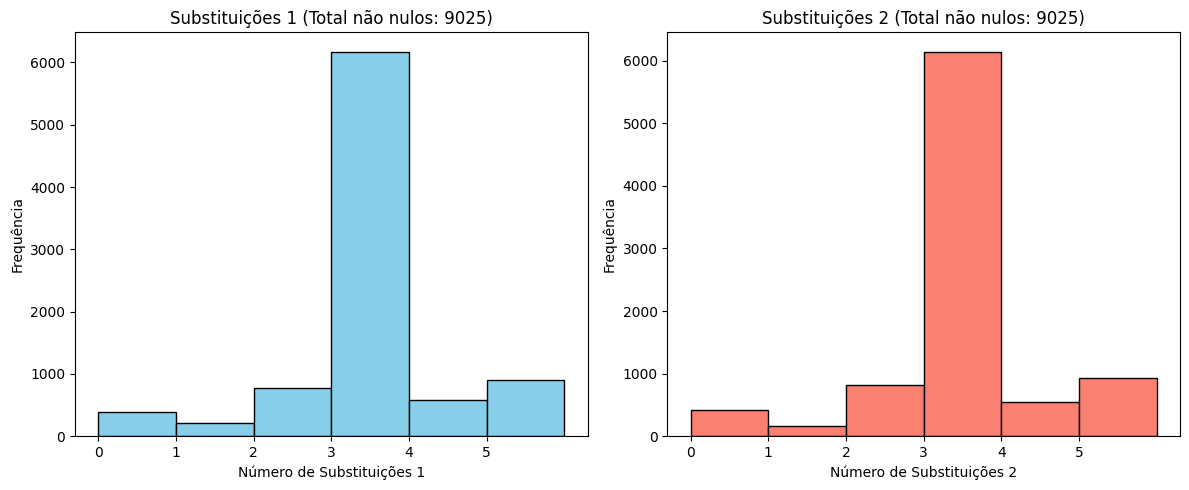

Tiro de meta 1 - média: 2.999113573407202
Tiro de meta 2 - média: 3.0001108033240995
Tiro de meta 1 - mediana: 3.0
Tiro de meta 2 - mediana: 3.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers.csv', 'Substituições 1', 'Substituições 2')

Podemos perceber que há uma grande concentração em '3 substituições' isso provavelmente se deve a uma regra que limitava a 3 substituições por jogo. Apesar dessa regra ter mudado em 2022 para 5 substituições máximas. A grande concentração de substituições em 3, sem alterar os resultados, comprova que a coluna está pouco relacionada ao número de gols. Por isso, vamos ignorar essa coluna, então partiremos para a próxima.

### Contra-ataques

Como fizemos com as outras colunas, vejamos a quantidade de dados que temos disponível: 18604 nulos (75.92%) e 5901 (24.08%), percebemos que 3/4 dos dados estão faltando. Agora vamos verificar as correlações em relação a 'gols': existe uma relação na ordem de 0.15 a 0.2 entre as colunas, apesar de não ser uma correlação enorme, não devemos desconsiderá-la. Podemos analisar que contra-ataques tem uma relação positiva com número de gols, e isso faz sentido na lógica do fotebol.

In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")

for col in ['Contra-ataques 1', 'Contra-ataques 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Contra-ataques 1
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------
Contra-ataques 2
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------


In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")
for g in ['Gols 1', 'Gols 2']:
    for s in ['Contra-ataques 1', 'Contra-ataques 2']:
        print(f"Correlação entre {g} e {s}: {df[g].corr(df[s]):.3f}")

Correlação entre Gols 1 e Contra-ataques 1: 0.158
Correlação entre Gols 1 e Contra-ataques 2: -0.180
Correlação entre Gols 2 e Contra-ataques 1: -0.145
Correlação entre Gols 2 e Contra-ataques 2: 0.206


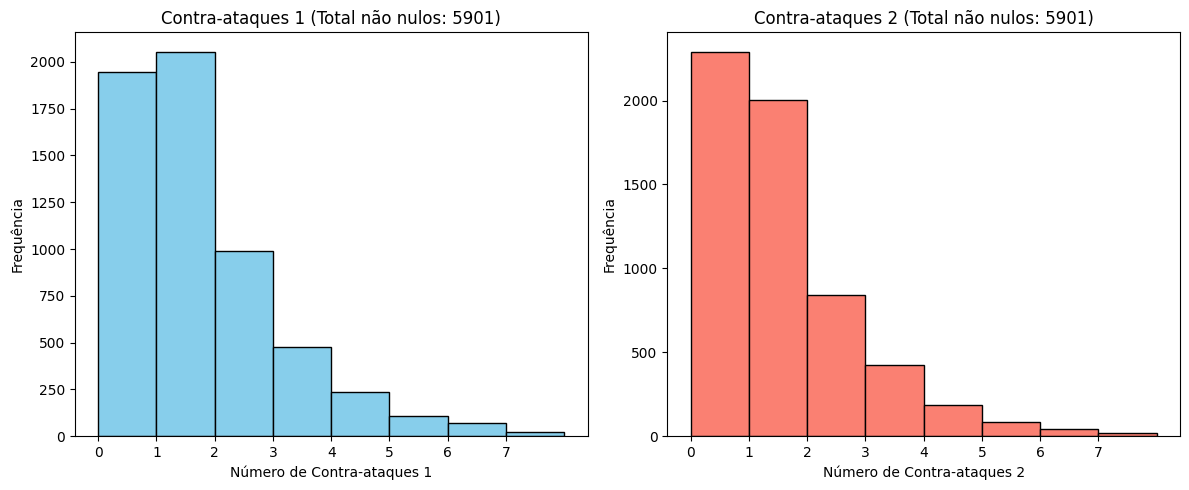

Tiro de meta 1 - média: 1.2758854431452296
Tiro de meta 2 - média: 1.1093035078800204
Tiro de meta 1 - mediana: 1.0
Tiro de meta 2 - mediana: 1.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers.csv', 'Contra-ataques 1', 'Contra-ataques 2')

Podemos perceber que há uma concentração do número de contra-ataques em valores baixos.

Vamos analisar as correlações abaixo. Cruzamentos do time adversário está ligado diretamente a contra-ataques, pois quando o time adversário tenta fazer um cruzamento, espaço para um contra-ataque é aberto. Outra correlação lógica seria quanto mais contra-ataques, mais chances de fazer gol, ou seja, gols aumentar. Chutes bloqueados do time adversário aumentarem também seriam uma boa suposição, pois nem todo contra-ataque é bem sucedido, levando a aumentar essa coluna. Vejamos:

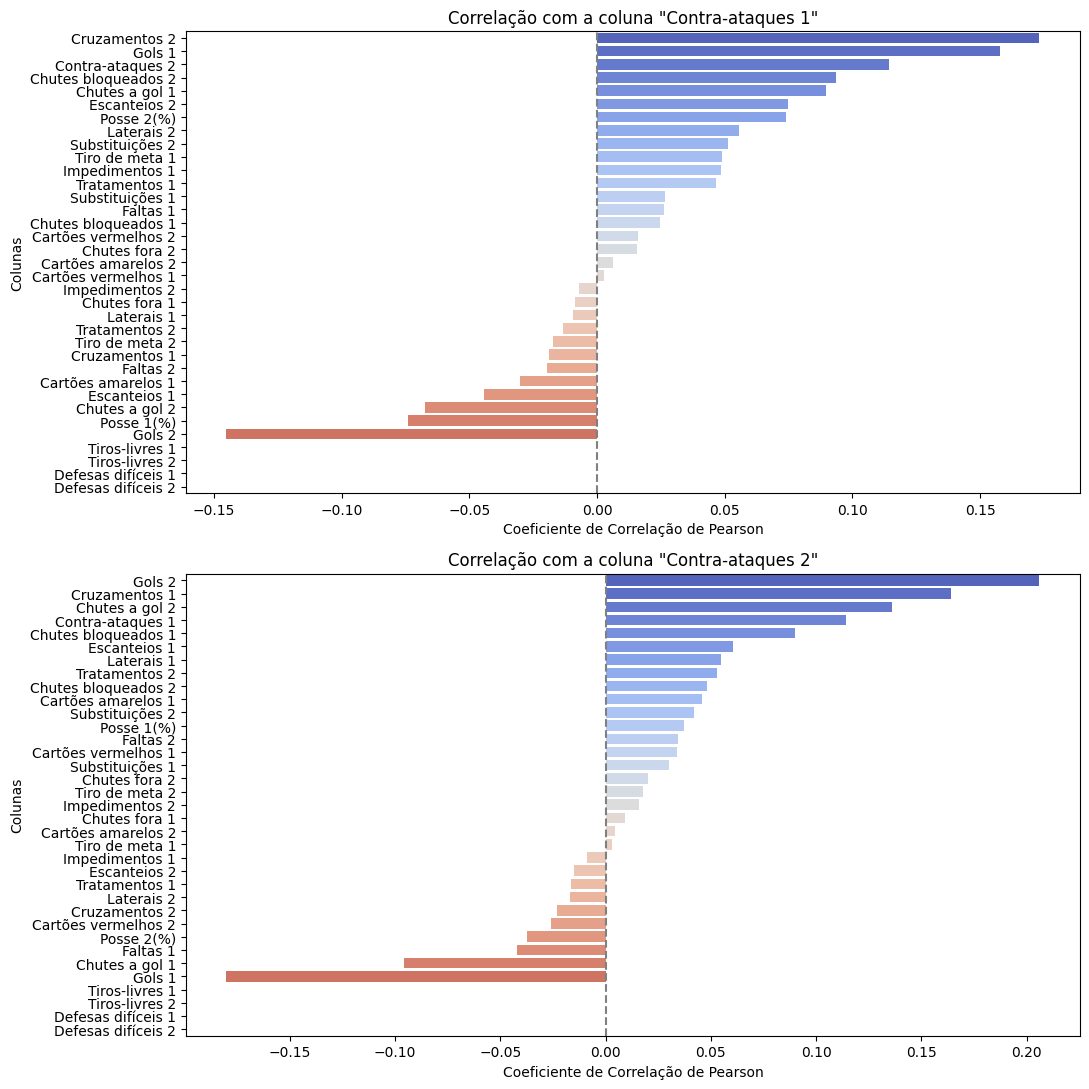

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def grafico_correlacoes(csv_path, colunas_alvo):
    # Lê o CSV
    df = pd.read_csv(csv_path)

    # Garante que só colunas numéricas sejam usadas na correlação
    df_numerico = df.select_dtypes(include='number')

    # Verifica se todas as colunas alvo existem no dataset
    for coluna in colunas_alvo:
        if coluna not in df_numerico.columns:
            raise ValueError(f"A coluna '{coluna}' não é numérica ou não está no dataset.")

    # Número de subgráficos (linhas)
    num_colunas = len(colunas_alvo)

    plt.figure(figsize=(11, 11))

    for i, coluna_alvo in enumerate(colunas_alvo, start=1):
        # Calcula a correlação da coluna alvo com todas as outras
        correlacoes = df_numerico.corr()[coluna_alvo].drop(labels=[coluna_alvo])

        # Ordena por valor da correlação
        correlacoes_ordenadas = correlacoes.sort_values(ascending=False)

        # Cria subgráfico
        plt.subplot(num_colunas, 1, i)  # Divide o espaço em linhas
        sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm', orient='h')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.title(f'Correlação com a coluna "{coluna_alvo}"')
        plt.xlabel('Coeficiente de Correlação de Pearson')
        plt.ylabel('Colunas')

    plt.tight_layout()
    plt.show()

grafico_correlacoes('saida_sem_outliers.csv', ['Contra-ataques 1', 'Contra-ataques 2'])

Acertamos em cheio. As correlações estão condizentes com a realidade, por tanto, podemos prosseguir para a formulação de colunas candidatas para nosso método KNN.

__Colunas candidatas:__
- Gols ✅
- Cruzamentos ❌
- Contra-ataques ❌
- Chutes a gol ✅
- Chutes bloqueados ❌

Vamos primeiramente verificar a quantidade de dados nessas colunas, se forem satisfatórias, verificaremos a correlação delas com 'Contra-ataques'

In [ ]:
df = pd.read_csv("saida_sem_outliers.csv")

for col in ['Gols 1', 'Gols 2', 'Cruzamentos 1', 'Cruzamentos 2', 'Contra-ataques 1', 'Contra-ataques 2', 'Chutes a gol 1', 'Chutes a gol 2', 'Chutes bloqueados 1', 'Chutes bloqueados 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Gols 1
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Gols 2
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Cruzamentos 1
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Cruzamentos 2
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Contra-ataques 1
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------
Contra-ataques 2
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------
Chutes a gol 1
nulos     : 12 (0.05%)
não nulos : 24493 (99.95%)
----------------------------------------
Chutes a gol 2
nulos     : 12 (0.05%)
não nulos : 24493 (99.95%)
----------------------------------------
Chutes bloqueados 1
nulos     : 16112 (65.75%)
não nulos : 8393 (34.25%)
----------------------------------------
Chutes bloqueados 2
nulos     : 16112 (6

✅ 'Gols': temos 100% dos dados não nulos, oque é um ótimo início. Em questão da correlação, 'gols' tem entre 0.15 e 0.2 de coeficiente de correlação, que é satisfatório para considerarmos essa coluna na formulação.

❌ 'Cruzamentos': podemos descartar de cara pela alta quantidade de nulos (65.21%), tornando difícil um bom aproveitamento da coluna. O mesmo ocorreu com 'Tiro de meta'.

❌ 'Contra-ataques': não podemos usar a própria coluna que queremos primeiramente, pois ela tem muitos dados faltantes (75.92%) e não nos ajudaria em praticamente nada, pois ou temos os dois dados ou não temos nenhum dos dois. Então vamos ignorar essa coluna também.

✅ 'Chutes a gol': temos praticamente todos os dados não nulos (99.95%), além disso tem entre 0.1 e 0.15 de coeficiente de correlação, apesar de ser baixo vamos usar para ajudar a compor o modelo do KNN.

❌ 'Chutes bloqueados': assim como 'Cruzamentos' temos muitos nulos (65.75%), não usaremos.

In [ ]:
def preencher_com_knn(caminho_entrada, caminho_saida, coluna_alvo, colunas_auxiliares, n_vizinhos=2):
    # Carrega os dados
    df = pd.read_csv(caminho_entrada)

    # Conta nulos antes
    nulos_antes = df[coluna_alvo].isnull().sum()

    # Remove linhas com nulos nas colunas auxiliares
    df_aux = df[colunas_auxiliares + [coluna_alvo]].dropna(subset=colunas_auxiliares)

    # Divide entre linhas com e sem alvo
    df_treino = df_aux[df_aux[coluna_alvo].notnull()]
    df_predicao = df_aux[df_aux[coluna_alvo].isnull()]

    if df_predicao.empty:
        print("[INFO] Nenhum valor nulo para preencher na coluna alvo.")
        df.to_csv(caminho_saida, index=False)
        return

    # Prepara treino
    X_train = df_treino[colunas_auxiliares]
    y_train = df_treino[coluna_alvo]

    # Prepara predição
    X_pred = df_predicao[colunas_auxiliares]

    # Modelo KNN
    model = KNeighborsRegressor(n_neighbors=n_vizinhos)
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_pred)

    # Preenche os nulos no dataframe original
    df.loc[df[coluna_alvo].isnull() & df[colunas_auxiliares].notnull().all(axis=1), coluna_alvo] = y_pred

    # Pós-preenchimento
    nulos_depois = df[coluna_alvo].isnull().sum()
    nulos_preenchidos = nulos_antes - nulos_depois
    media_preenchida = y_pred.mean()

    # Salva resultado
    df.to_csv(caminho_saida, index=False)

    # Relatório
    print(f"[RELATÓRIO - {coluna_alvo}]")
    print(f"Total de nulos antes:    {nulos_antes}")
    print(f"Nulos preenchidos:       {nulos_preenchidos}")
    print(f"Nulos restantes:         {nulos_depois}")
    print(f"Média dos valores previstos: {media_preenchida:.2f}\n")

preencher_com_knn('saida_sem_outliers_preenchido.csv', 'saida_sem_outliers_preenchido.csv', 'Contra-ataques 1', ['Gols 1', 'Chutes a gol 1'])
preencher_com_knn('saida_sem_outliers_preenchido.csv', 'saida_sem_outliers_preenchido.csv', 'Contra-ataques 2', ['Gols 2', 'Chutes a gol 2'])

[RELATÓRIO - Contra-ataques 1]
Total de nulos antes:    18604
Nulos preenchidos:       18595
Nulos restantes:         9
Média dos valores previstos: 1.32

[RELATÓRIO - Contra-ataques 2]
Total de nulos antes:    18604
Nulos preenchidos:       18595
Nulos restantes:         9
Média dos valores previstos: 0.82



Agora, vamos ver os resultados plotando um histograma.

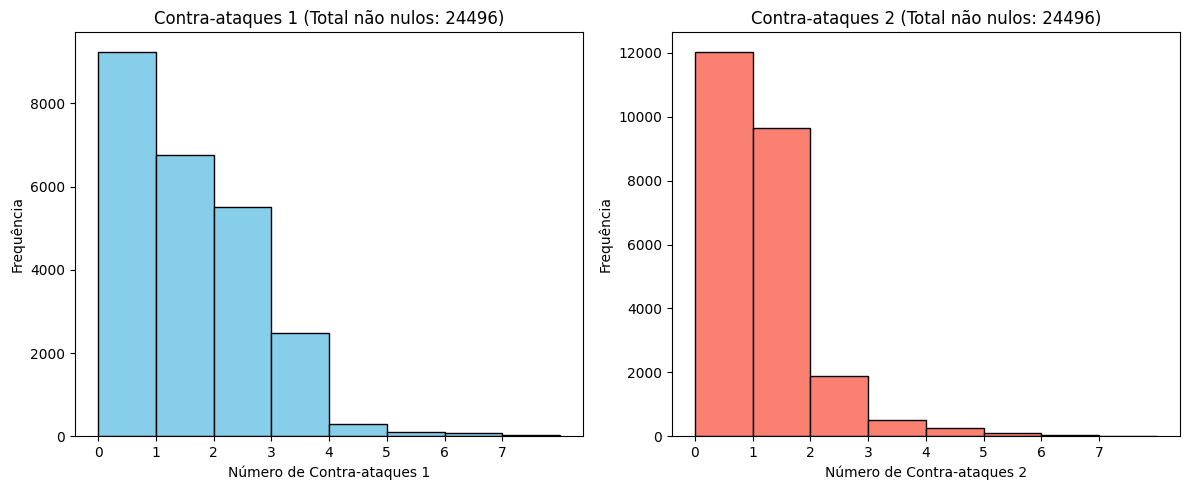

Tiro de meta 1 - média: 1.3079278249510125
Tiro de meta 2 - média: 0.8875530698889614
Tiro de meta 1 - mediana: 1.0
Tiro de meta 2 - mediana: 1.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers_preenchido.csv', 'Contra-ataques 1', 'Contra-ataques 2')

O comportamento do gráfico não mudou de forma brusca em relação ao original.

#Análise exploratória de dados


## Tiros-livres

### Verificação de Coerência

A primeira verificação lógica é que o número de Tiros Livres recebidos por um time não deve ultrapassar a soma das Faltas cometidas + Impedimentos do time adversário. Isso se baseia no fato de que:

* A maioria dos tiros livres resulta de faltas ou
impedimentos.

* Há raros casos de recuo ao goleiro, mas são exceções e não justificam valores muito altos.

* Nem todas as faltas geram tiros livres (ex: vantagem ou pênalti).

In [ ]:
df.loc[df['Tiros-livres 1'] > df['Impedimentos 2'] + df['Faltas 2'] ,['Tiros-livres 1', 'Impedimentos 2', 'Faltas 2']].shape
#com o '.shape', percebe-se que são 28 linhas com dados incoerentes, apesar que os valores são próximos

(31, 3)

In [ ]:
df.loc[df['Tiros-livres 2'] > df['Impedimentos 1'] + df['Faltas 1'], ['Tiros-livres 2', 'Impedimentos 1', 'Faltas 1']].shape

(28, 3)

Foram encontrados 31 registros incoerentes para o time 1 e 28 para o time 2, em que a quantidade de Tiros-Livres é maior que a soma de impedimento mais falta. Como não é impossível, apenas improvável que haja recuos para o goleiro, então esse caso pode acontecer,

### Proporção de Tiros Livres por Faltas + Impedimentos

Para entender melhor a relação entre essas variáveis, criamos a variável "proporcao_tiro_falta" para as estatísticas do time 1 e "proporcao" para o time 2 e analisamos o seu histograma

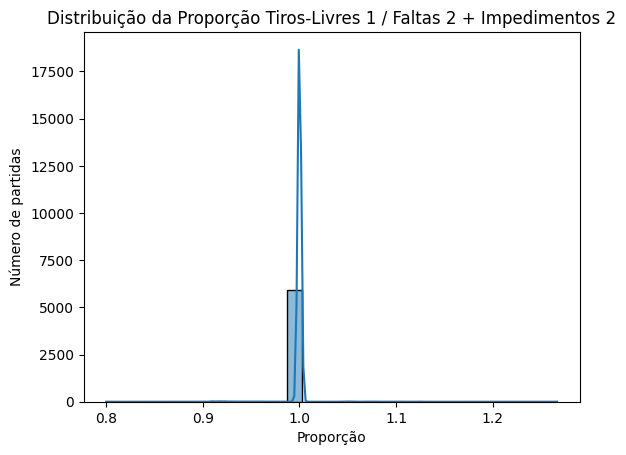

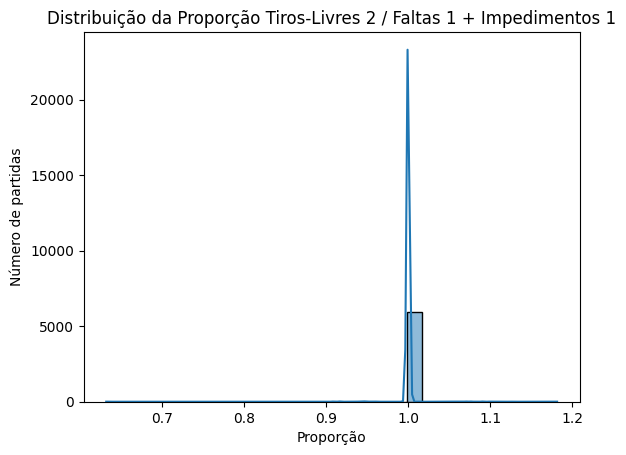

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df['proporcao_tiro_falta'] = df['Tiros-livres 1'] / (df['Faltas 2'] + df['Impedimentos 2'])
sns.histplot(df['proporcao_tiro_falta'], bins=30, kde=True)
plt.title('Distribuição da Proporção Tiros-Livres 1 / Faltas 2 + Impedimentos 2')
plt.xlabel('Proporção')
plt.ylabel('Número de partidas')
plt.show()
df['proporcao'] = df['Tiros-livres 2'] / (df['Faltas 1'] + df['Impedimentos 1'])
sns.histplot(df['proporcao'], bins=30, kde=True)
plt.title('Distribuição da Proporção Tiros-Livres 2 / Faltas 1 + Impedimentos 1')
plt.xlabel('Proporção')
plt.ylabel('Número de partidas')
plt.show()
#analisando o gráfico, percebe-se que a relação entre Tiros Livre e (Faltas + Impedimento) é quase 1 para 1 como o esperado
#Note que quando o time 2 comete falta ou impedimento, o time 1 é quem cobra

Os gráficos mostraram uma distribuição próxima de 1 para ambos os casos, o que confirma a suposição teórica da relação entre as variáveis.

### Investigando o Impacto Isolado das Faltas

Analisamos também a relação de Tiros-Livres apenas com Faltas

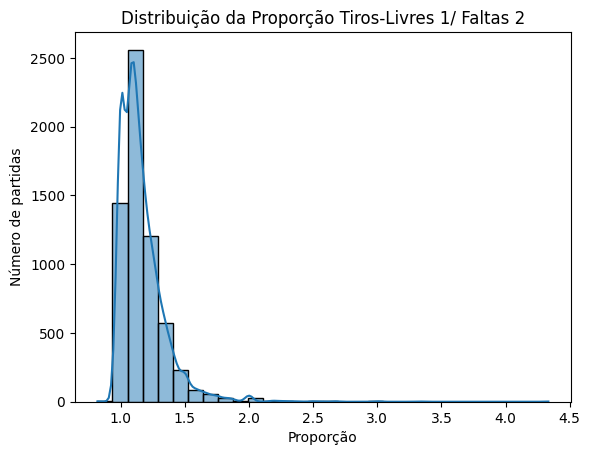

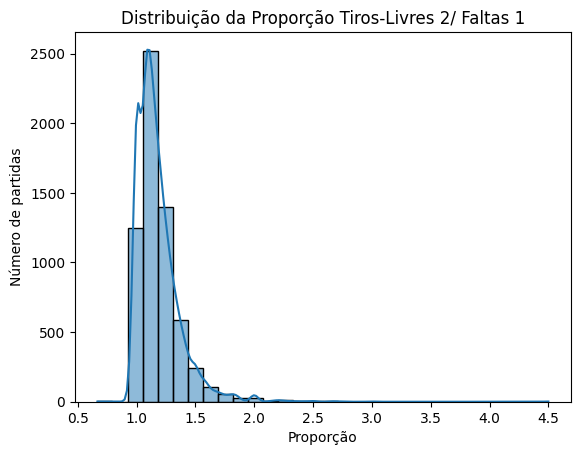

In [ ]:
df['proporcao_tiro_falta'] = df['Tiros-livres 1'] / (df['Faltas 2'])
sns.histplot(df['proporcao_tiro_falta'], bins=30, kde=True)
plt.title('Distribuição da Proporção Tiros-Livres 1/ Faltas 2')
plt.xlabel('Proporção')
plt.ylabel('Número de partidas')
plt.show()
df['proporcao2'] = df['Tiros-livres 2'] / (df['Faltas 1'])
sns.histplot(df['proporcao2'], bins=30, kde=True)
plt.title('Distribuição da Proporção Tiros-Livres 2/ Faltas 1')
plt.xlabel('Proporção')
plt.ylabel('Número de partidas')
plt.show()
#Nesse caso, a estimativa já não é tão boa quanto o outro, o que leva a crer que a substituição dos valores nulos de Tiros Livres seja melhor com (faltas + impedimentos)

A estimativa foi menos precisa. Portanto, para preencher valores nulos de Tiros-livres, a soma de Faltas + Impedimentos parece ser uma melhor escolha de imputação.

### Análise de Nulos

In [ ]:
print(df['Tiros-livres 1'].isnull().sum(),
df['Faltas 2'].isnull().sum(),
df['Impedimentos 2'].isnull().sum())


21470 2322 2774


In [ ]:
print(df['Tiros-livres 2'].isnull().sum(),
df['Faltas 1'].isnull().sum(),
df['Impedimentos 1'].isnull().sum())


21470 2322 2774


A quantidade de valores ausentes em Tiros-Livres é muito maior do que nas colunas de Faltas e Impedimentos, o que valida a ideia de usar estas como estimativas para imputação.

### Comparação das Distribuições

Text(0.5, 1.0, 'Tiros Livres 1')

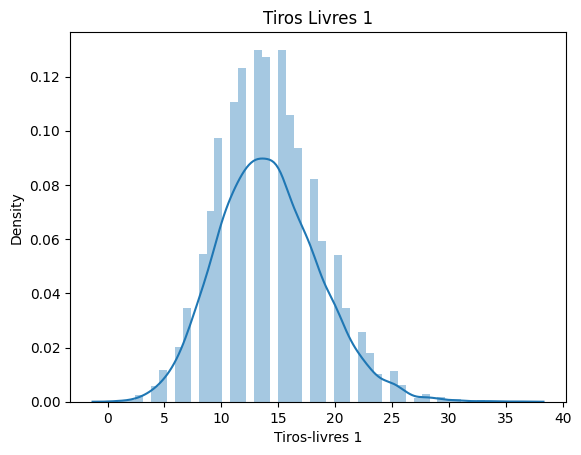

In [ ]:
sns.distplot(df['Tiros-livres 1']).set_title('Tiros Livres 1')

Text(0.5, 1.0, 'F2 + I2')

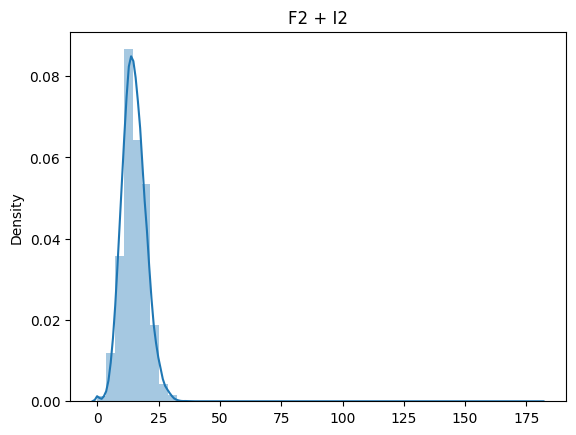

In [ ]:
sns.distplot(df['Impedimentos 2']+ df['Faltas 2']).set_title('F2 + I2')

Text(0.5, 1.0, 'Tiros Livres 2')

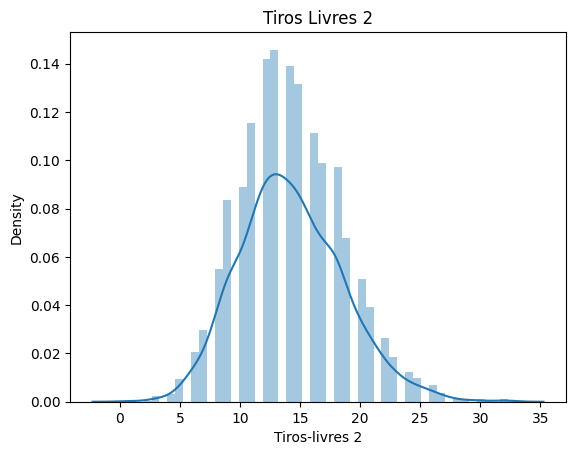

In [ ]:
sns.distplot(df['Tiros-livres 2']).set_title('Tiros Livres 2')

Text(0.5, 1.0, 'F1 + I1')

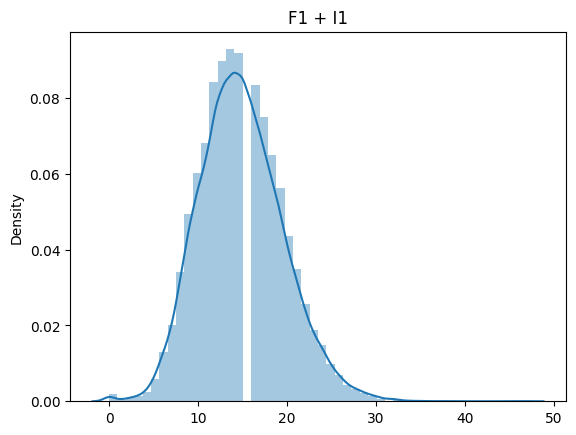

In [ ]:
sns.distplot(df['Impedimentos 1']+ df['Faltas 1']).set_title('F1 + I1')

As distribuições são semelhantes, porém observamos outliers em Faltas, especialmente um valor de 180 faltas, que foi identificado como um outlier claro, o que faz com que o gráfico de faltas seja mais extenso no eixo x

In [ ]:
df['Faltas 1'].describe() #máximo de 46
df['Faltas 2'].describe() #máximo de 180, claro outlier

,Faltas 2
count,25394.000000
mean,12.946444
std,4.608542
min,0.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,180.000000


In [ ]:
df['Impedimentos 1'].describe() #max 23
df['Impedimentos 2'].describe() #max 15

,Impedimentos 2
count,24942.000000
mean,1.968527
std,1.681298
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,15.000000


### Tratamento de Outliers e Preenchimento de Nulos

Após considerar a análise, optamos por substituir os valores nulos de Tiros-livres pela soma de Faltas + Impedimentos.

In [ ]:
#após tratamento de dados de Impedimentos e Faltas, podemos substituir os valores nulos de Tiros livres, pela soma dos dois, pelos argumentos mostrados acima
# Cria a soma das colunas auxiliares
substituto1 = df['Faltas 2'] + df['Impedimentos 2']

# Substitui apenas onde Tiros-livres 1 é nulo
df['Tiros-livres 1'] = df['Tiros-livres 1'].fillna(substituto1) #colocar (inplace = True) para substituir nos df
df['Tiros-livres 1'].describe()
print("quantidade de Tiros-Livres 1 nulos:",df['Tiros-livres 1'].isnull().sum())

substituto2 = df['Faltas 1'] + df['Impedimentos 1']

# Substitui apenas onde Tiros-livres 2 é nulo
df['Tiros-livres 2'] = df['Tiros-livres 2'].fillna(substituto2) #colocar (inplace = True) para substituir nos df
df['Tiros-livres 2'].describe()
print("quantidade de Tiros-Livres 2 nulos:",df['Tiros-livres 2'].isnull().sum())

quantidade de Tiros-Livres 1 nulos: 2541
quantidade de Tiros-Livres 2 nulos: 2541


A substituição reduziu significativamente os valores ausentes, mantendo a coerência com a distribuição dos dados.

#### Conclusão

In [ ]:
df.drop(columns = ['proporcao_tiro_falta','proporcao','proporcao2'], inplace = True)

## Laterais

### Correlação com Outras Variáveis



Antes de aplicar qualquer estratégia de imputação, é importante entender como a variável Laterais se relaciona com as demais variáveis do conjunto.

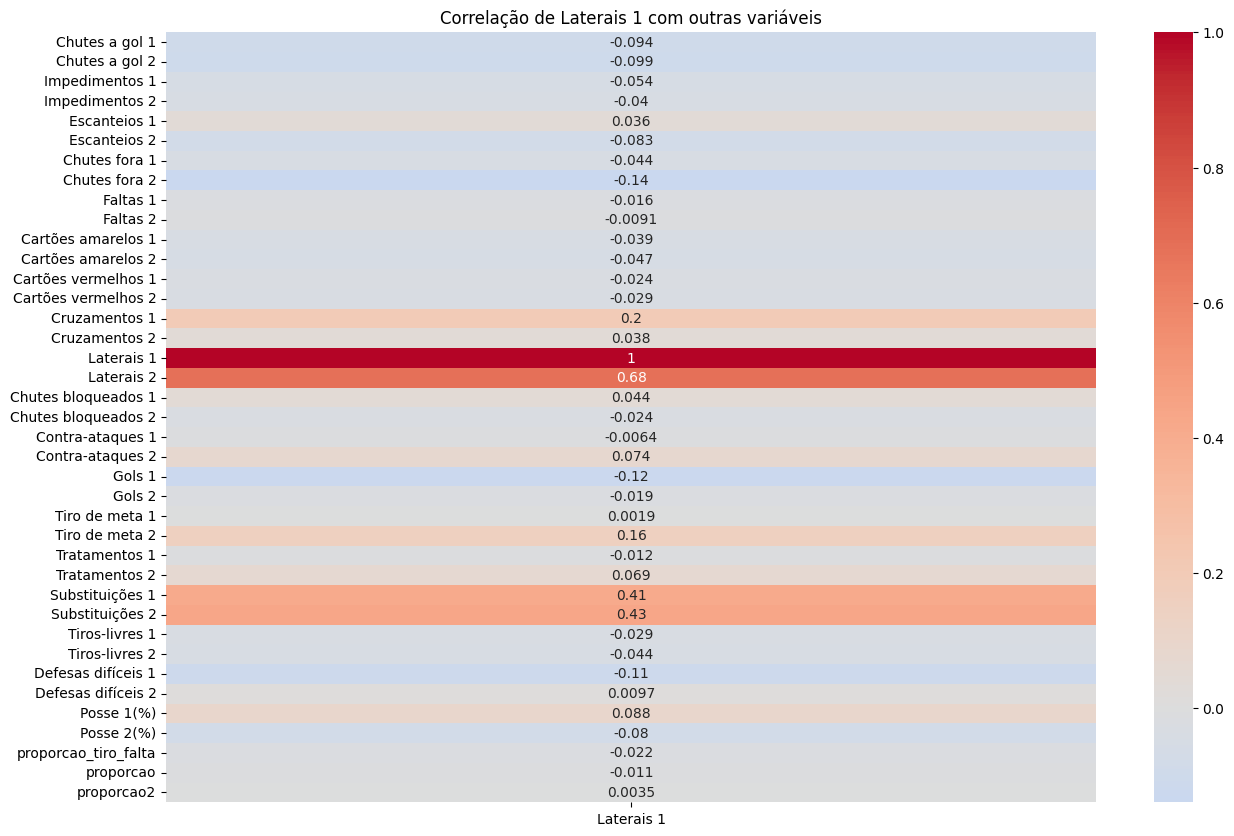

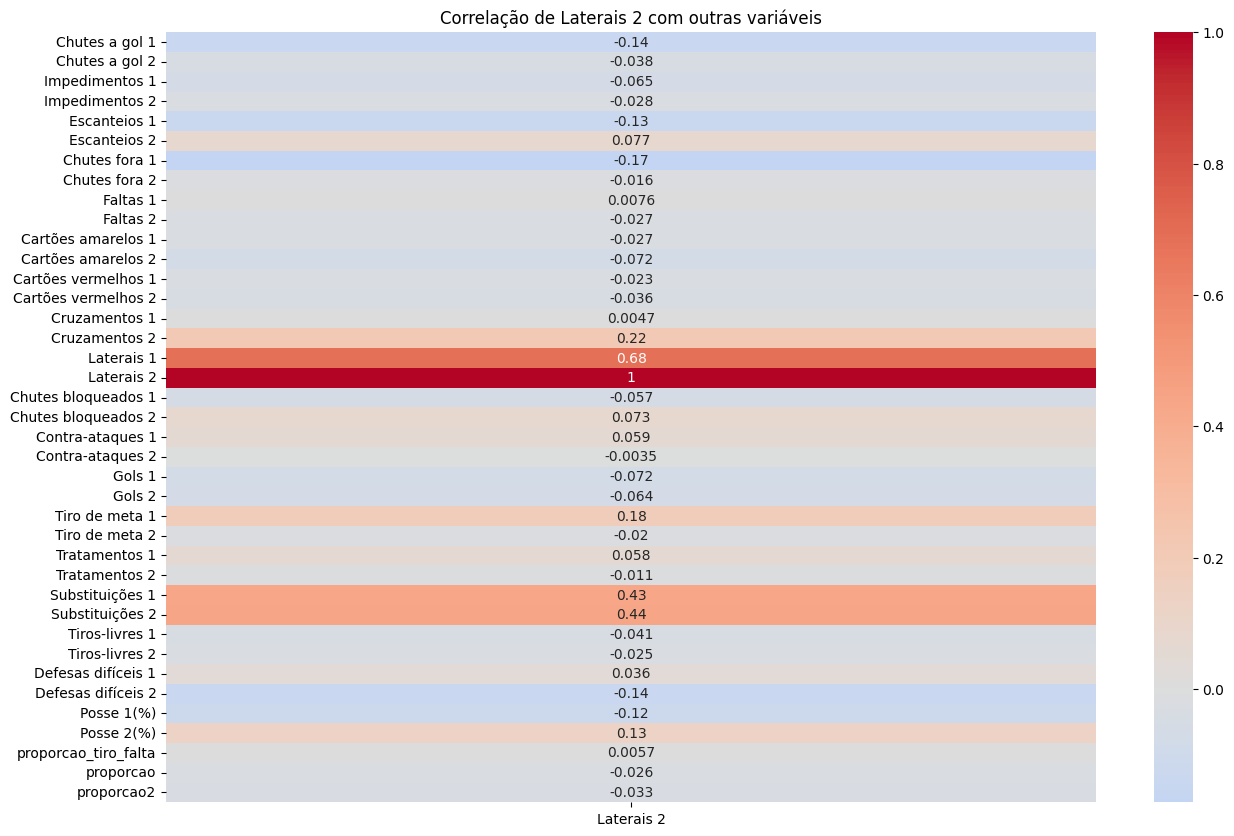

In [ ]:

# Seleciona apenas colunas numéricas
dados_numericos = df.select_dtypes(include='number')

# Cria a matriz de correlação
correlacao = dados_numericos.corr()

# Visualiza a correlação com heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlacao[['Laterais 1']], annot=True, cmap='coolwarm', center=0)
plt.title('Correlação de Laterais 1 com outras variáveis')
plt.show()

# Repete para o time 2
plt.figure(figsize=(15, 10))
sns.heatmap(correlacao[['Laterais 2']], annot=True, cmap='coolwarm', center=0)
plt.title('Correlação de Laterais 2 com outras variáveis')
plt.show()
#heatmap para saber a relação de laterais com outras variáveis

Observações:

Diferente de variáveis como Tiros-Livres, Laterais não apresenta uma correlação forte ou direta com outras métricas do jogo.

Nem mesmo variáveis intuitivamente relacionadas, como Posse de Bola, Substituições ou Faltas, mostraram correlação significativa.

Isso indica que Laterais é mais imprevisível e depende do estilo de jogo, do adversário e do contexto tático.

### Distribuição de Laterais por Time

Unimos os dados de Laterais 1 e Laterais 2 em um único dataframe para analisar a distribuição por time:

In [ ]:
laterais_1 = df[['Time 1', 'Laterais 1']].rename(columns={'Time 1': 'Time', 'Laterais 1': 'Laterais'})
laterais_2 = df[['Time 2', 'Laterais 2']].rename(columns={'Time 2': 'Time', 'Laterais 2': 'Laterais'})
laterais_total = pd.concat([laterais_1, laterais_2])


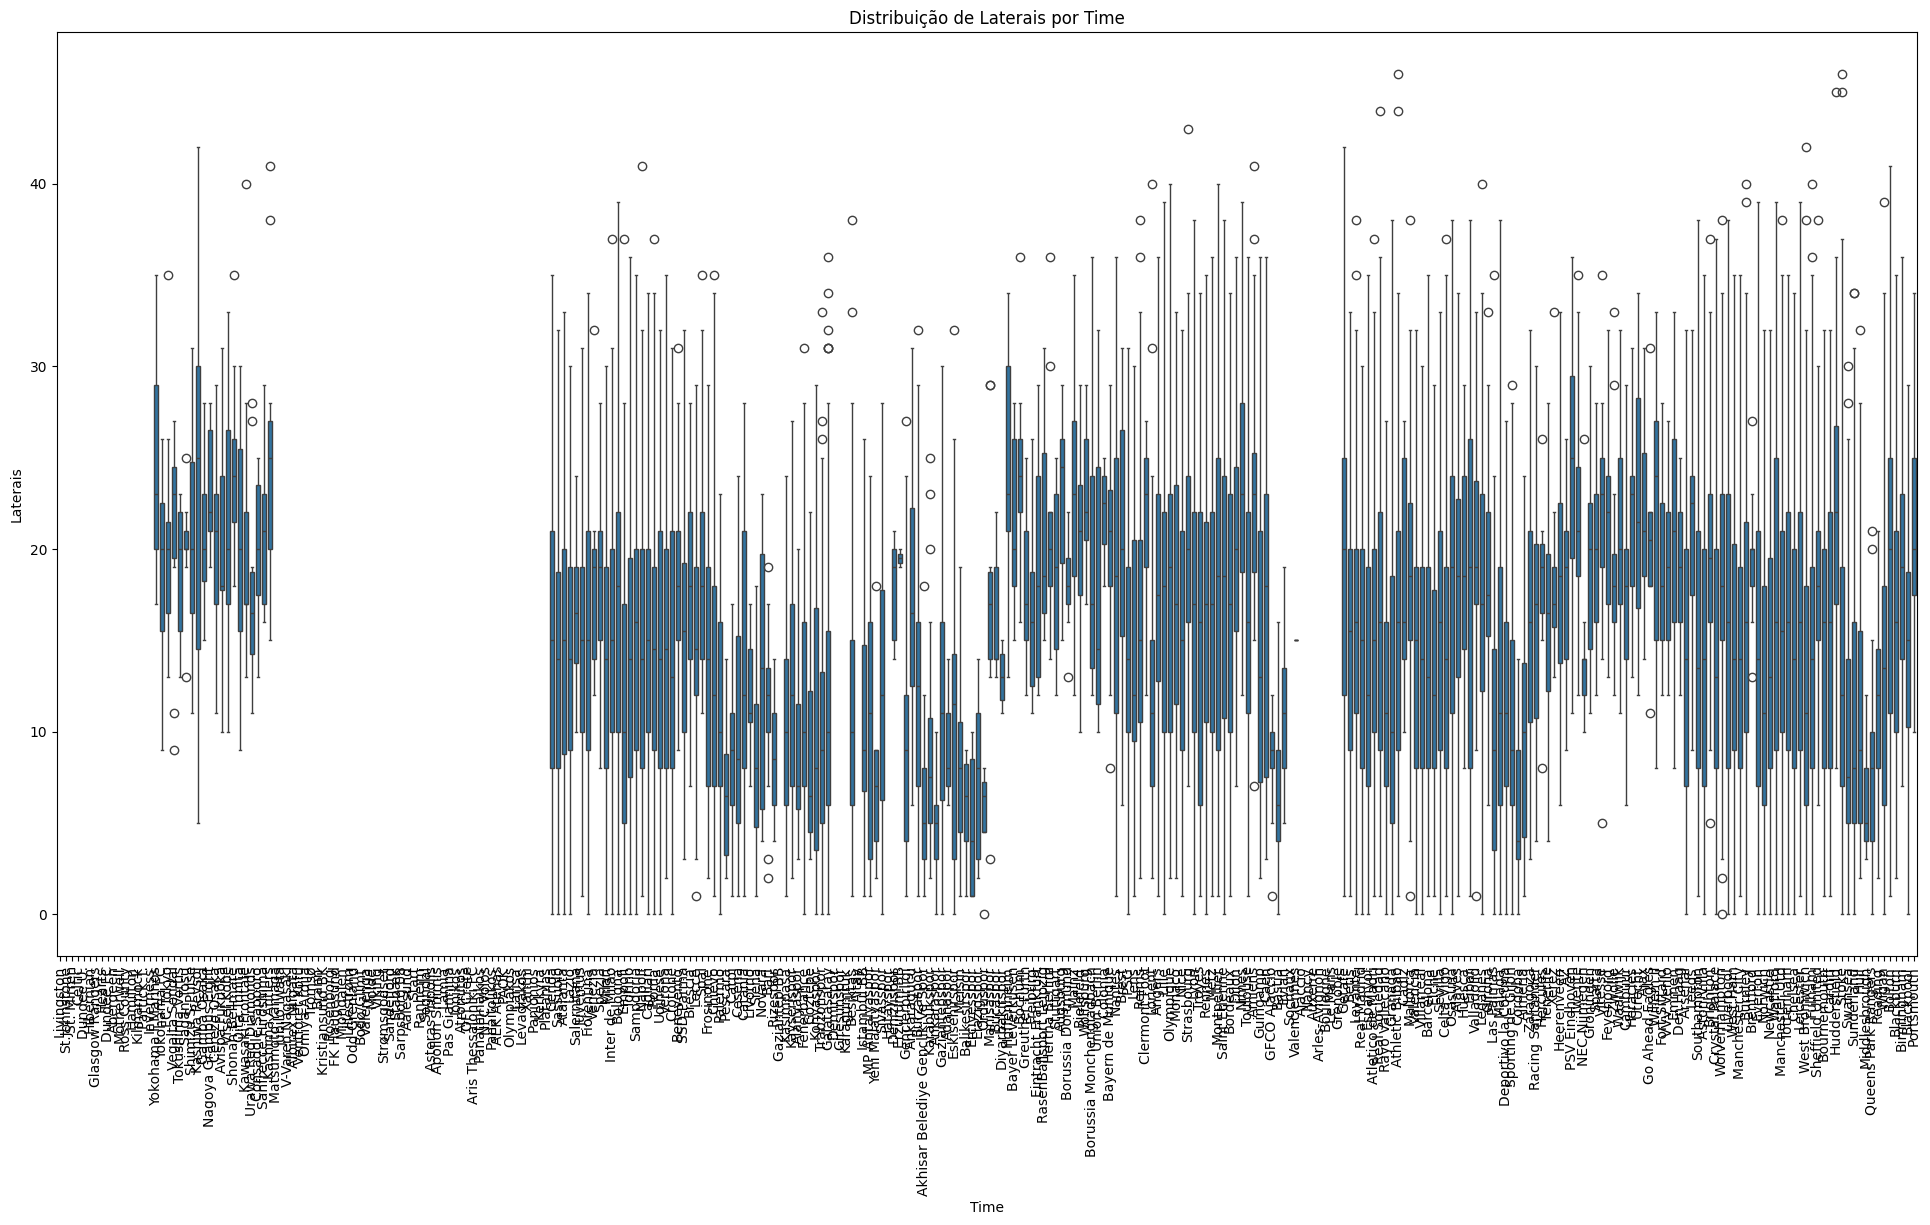

In [ ]:
laterais_total = laterais_total.reset_index(drop=True)
plt.figure(figsize=(24,12))
sns.boxplot(x='Time', y='Laterais', data=laterais_2)
plt.xticks(rotation=90)
plt.title('Distribuição de Laterais por Time')
plt.show()
#tentativa de analisar se os laterais dependem do time ou não

###Tentativa de Imputação por Partida Anterior

 Foi testada a hipótese de preencher os valores ausentes de Laterais com base na última partida do mesmo time.

No entanto:
  Os times que possuem valores ausentes de Laterais apresentam ausência sistemática, ou seja, o dado está faltando em todas as partidas daquele time.

### Conclusão

In [ ]:
df['Laterais 1'] = df['Laterais 1'].fillna(df['Laterais 1'].median(),inplace=True)
df['Laterais 2'] = df['Laterais 2'].fillna(df['Laterais 2'].median(),inplace=True)

Como não há um forte preditor, valores nulos em Laterais devem ser tratados com cuidados estatísticos como computação pela mediana ou pela média geral por time. No nosso caso, foi usado a mediana geral

##Cruzamentos

###  Investigando a Correlação dos Cruzamentos com Outras Variáveis

Inicialmente, analisamos como os Cruzamentos 1 se correlacionam com outras variáveis numéricas do dataset.

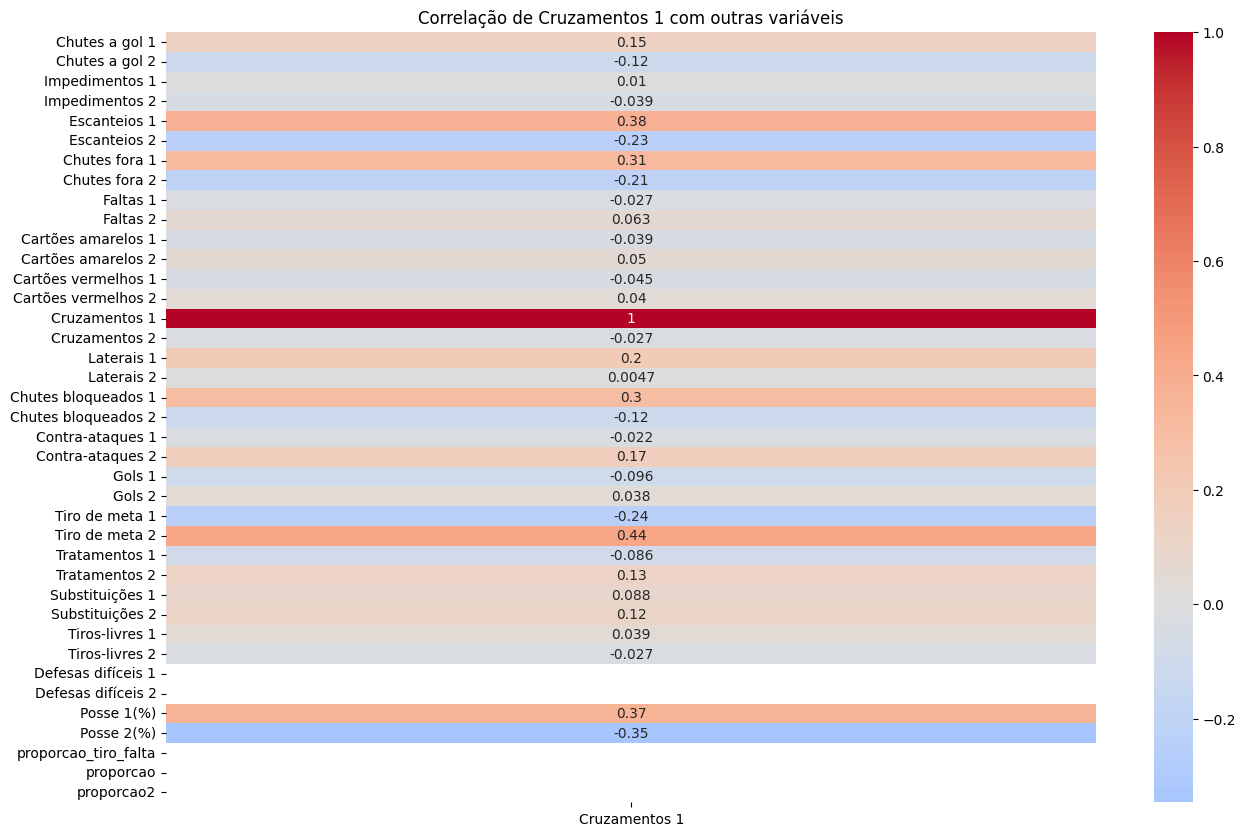

In [ ]:
# Seleciona apenas colunas numéricas
dados_numericos = df.select_dtypes(include='number')

# Cria a matriz de correlação
correlacao = dados_numericos.corr()

# Visualiza a correlação com heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlacao[['Cruzamentos 1']], annot=True, cmap='coolwarm', center=0)
plt.title('Correlação de Cruzamentos 1 com outras variáveis')
plt.show()

Observação: A correlação dos cruzamentos com outras variáveis é relativamente baixa. Isso já sugere que o número de cruzamentos depende de múltiplos fatores e não tem forte relação linear com uma variável isolada.



### Tentativa de Estimativa de Cruzamentos com Base em Derivadas

Assumimos que os cruzamentos podem ser classificados em:

Certos → quando geram chutes a gol, chutes fora, chutes bloqueados. (bola chega no atacante)

Errados → quando resultam em escanteios, laterais, contra-ataques ou tiros de meta. (bola não chega no atacante)

In [ ]:
df['Cruzamentos certos 1'] = df['Chutes a gol 1'] + df['Chutes fora 1'] + df['Chutes bloqueados 1'] #+ df['Gols 1']
df['Cruzamentos errados 1'] = df['Contra-ataques 2'] + df['Escanteios 1'] + df['Laterais 2'] + df['Tiro de meta 2']
df['Cruzamento total 1'] = df['Cruzamentos certos 1']  + df['Cruzamentos errados 1']


Analisando a Correlação entre Cruzamentos e Ações Derivadas

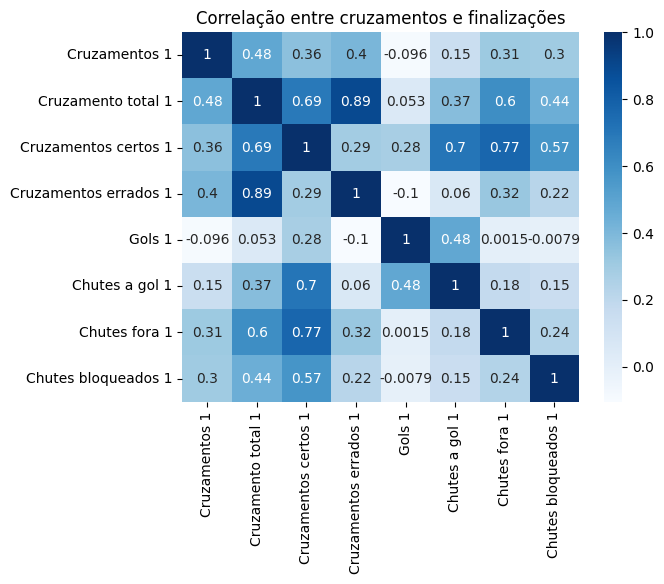

In [ ]:
colunas_interesse = ['Cruzamentos 1','Cruzamento total 1','Cruzamentos certos 1', 'Cruzamentos errados 1', 'Gols 1', 'Chutes a gol 1', 'Chutes fora 1', 'Chutes bloqueados 1']
sns.heatmap(df[colunas_interesse].corr(), annot=True, cmap='Blues')
plt.title("Correlação entre cruzamentos e finalizações")
plt.show()

Ainda que algumas correlações apareçam (ex: chutes e cruzamentos certos), os valores não são suficientemente fortes para justificar o uso da variável Cruzamentos 1 como preditora.

 ### Análise Proporcional de Resultados por Cruzamento

Foram criadas métricas de proporção entre resultados ofensivos/defensivos e o total de cruzamentos:

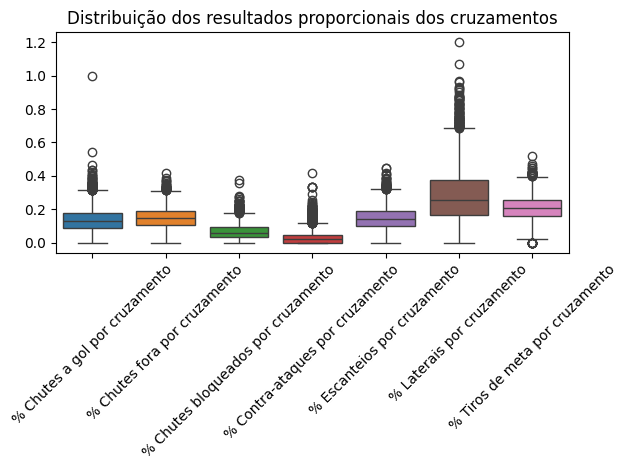

In [ ]:
df['% Chutes a gol por cruzamento'] = df['Chutes a gol 1'] / df['Cruzamento total 1']
df['% Chutes fora por cruzamento'] = df['Chutes fora 1'] / df['Cruzamento total 1']
df['% Chutes bloqueados por cruzamento'] = df['Chutes bloqueados 1'] / df['Cruzamento total 1']
df['% Contra-ataques por cruzamento'] = df['Contra-ataques 2'] / df['Cruzamento total 1']
df['% Escanteios por cruzamento'] = df['Escanteios 1'] / df['Cruzamento total 1']
df['% Laterais por cruzamento'] = df['Laterais 1'] / df['Cruzamento total 1']
df['% Tiros de meta por cruzamento'] = df['Tiro de meta 2'] / df['Cruzamento total 1']
colunas_proporcionais = [
    '% Chutes a gol por cruzamento',
    '% Chutes fora por cruzamento',
    '% Chutes bloqueados por cruzamento',
    '% Contra-ataques por cruzamento',
    '% Escanteios por cruzamento',
    '% Laterais por cruzamento',
    '% Tiros de meta por cruzamento'
]

sns.boxplot(data=df[colunas_proporcionais])
plt.xticks(rotation=45)
plt.title("Distribuição dos resultados proporcionais dos cruzamentos")
plt.tight_layout()
plt.show()


A análise mostra alta variabilidade, o que reforça a ideia de que cruzamentos dependem de múltiplos fatores e não têm padrão estável ou previsível.

In [ ]:
df[colunas_proporcionais].mean().sort_values(ascending=False)


,0
% Laterais por cruzamento,0.282896
% Tiros de meta por cruzamento,0.208859
% Chutes fora por cruzamento,0.148216
% Escanteios por cruzamento,0.145332
% Chutes a gol por cruzamento,0.136725
% Chutes bloqueados por cruzamento,0.065806
% Contra-ataques por cruzamento,0.032513


### Comparação com Limites Estimados

#### Limite Superior Estimado

Soma das possíveis consequências de cruzamentos:

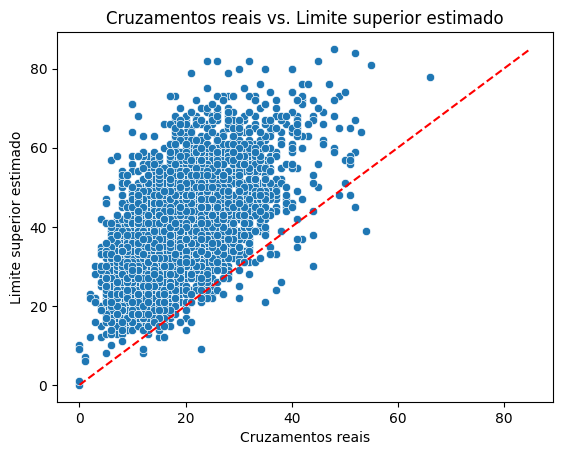

In [ ]:
df['limite_superior'] = (df['Chutes a gol 1'] + df['Escanteios 1'] + df['Chutes fora 1']+ df['Chutes bloqueados 1'] + df['Laterais 1'] + df['Contra-ataques 2'] + df['Tiro de meta 2'])
sns.scatterplot(x='Cruzamentos 1', y='limite_superior', data=df)
plt.title("Cruzamentos reais vs. Limite superior estimado")
plt.xlabel("Cruzamentos reais")
plt.ylabel("Limite superior estimado")
plt.plot([0, df[['Cruzamentos 1', 'limite_superior']].max().max()],
         [0, df[['Cruzamentos 1', 'limite_superior']].max().max()],
         'r--')  # linha de referência
plt.show()


#### Limite Inferior Estimado

Considerando apenas os piores cenários:

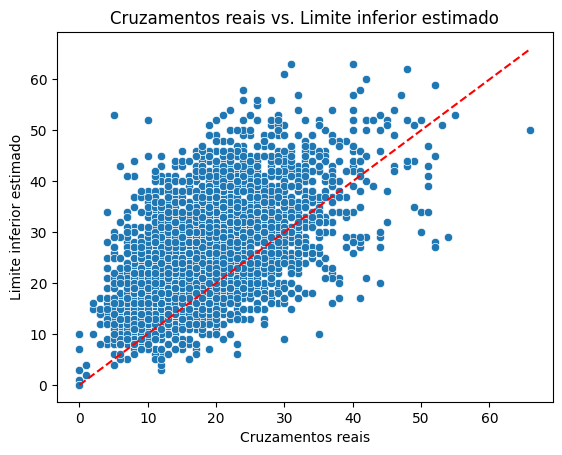

,Cruzamentos 1,limite_inferior
Cruzamentos 1,1.000000,0.538528
limite_inferior,0.538528,1.000000


In [ ]:
df['limite_inferior'] = df['Tiro de meta 2']+ df['Escanteios 1'] + df['Laterais 1'] + df['Contra-ataques 2']
#maioria dos tiros de meta 2 seriam derivados dos chutes fora, chutes bloqueados gerariam escanteios e contra ataques
sns.scatterplot(x='Cruzamentos 1', y='limite_inferior', data=df)
plt.title("Cruzamentos reais vs. Limite inferior estimado")
plt.xlabel("Cruzamentos reais")
plt.ylabel("Limite inferior estimado")
plt.plot([0, df[['Cruzamentos 1', 'limite_inferior']].max().max()],
         [0, df[['Cruzamentos 1', 'limite_inferior']].max().max()],
         'r--')  # linha de referência
plt.show()
df[['Cruzamentos 1', 'limite_inferior']].corr()

#### Média dos Limites

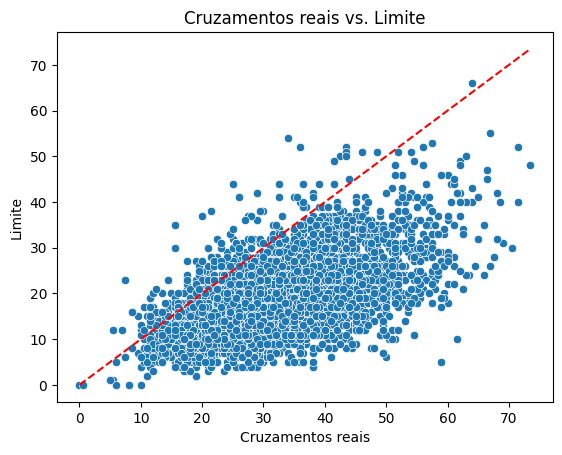

,limite,Cruzamentos 1
limite,1.000000,0.568135
Cruzamentos 1,0.568135,1.000000


In [ ]:
df['limite'] = (df['limite_superior'] + df['limite_inferior'])/2
sns.scatterplot(x='limite', y='Cruzamentos 1', data=df)
plt.title("Cruzamentos reais vs. Limite")
plt.xlabel("Cruzamentos reais")
plt.ylabel("Limite")
plt.plot([0, df[['limite', 'Cruzamentos 1']].max().max()],
         [0, df[['limite', 'Cruzamentos 1']].max().max()],
         'r--')  # linha de referência
plt.show()
df[['limite', 'Cruzamentos 1']].corr()

Resultado: As correlações com os limites estimados também são fracas, e os pontos estão muito dispersos.

### Tentativa de Previsão de Cruzamentos com Cruzamentos Certos e Errados

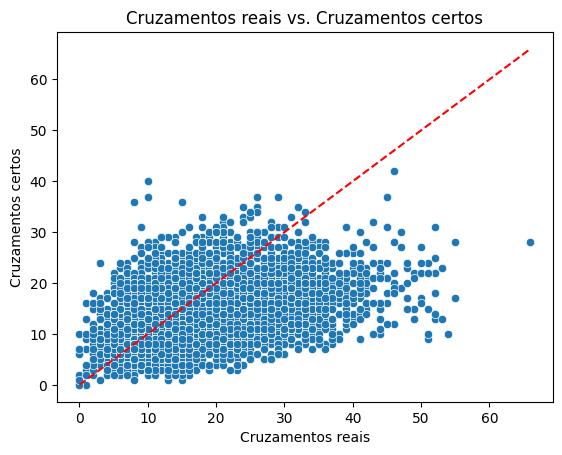

,cruzamento_c,Cruzamentos 1
cruzamento_c,1.000000,0.357831
Cruzamentos 1,0.357831,1.000000


In [ ]:
#possíveis derivadas de cruzamentos certos: chute a gol, chutes fora, chutes bloqueados
#possíveis derivadas de cruzamentos errados: laterais, escanteio e tiro de meta 2
#voltando a essa hipótese, vamos ver como se comportam os dois tipos de cruzamentos
#Primeiro analisando a distribuição dos cruzamentos certos com os cruzamentos totais
df['cruzamento_c'] = df['Chutes a gol 1'] + df['Chutes fora 1'] + df['Chutes bloqueados 1']
sns.scatterplot(x='Cruzamentos 1', y='cruzamento_c', data=df)
plt.title("Cruzamentos reais vs. Cruzamentos certos")
plt.xlabel("Cruzamentos reais")
plt.ylabel("Cruzamentos certos")
plt.plot([0, df[['Cruzamentos 1', 'cruzamento_c']].max().max()],
         [0, df[['Cruzamentos 1', 'cruzamento_c']].max().max()],
         'r--')  # linha de referência
plt.show()
df[['cruzamento_c', 'Cruzamentos 1']].corr()

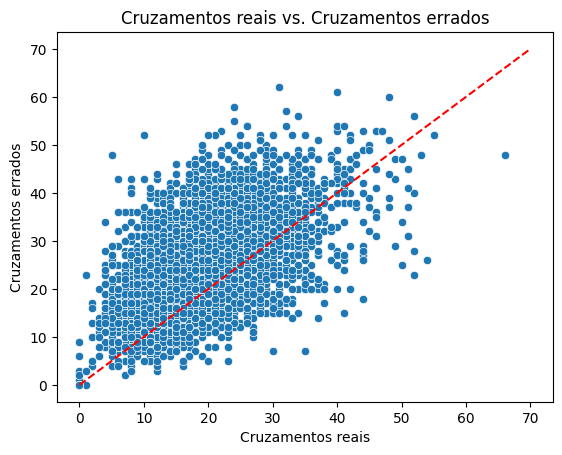

,cruzamento_e,Cruzamentos 1
cruzamento_e,1.000000,0.526406
Cruzamentos 1,0.526406,1.000000


In [ ]:
#analisando a distribuição dos cruzamentos errados com os cruzamentos totais
df['cruzamento_e'] = df['Laterais 1'] + df['Escanteios 1'] + df['Tiro de meta 2']
sns.scatterplot(x='Cruzamentos 1', y='cruzamento_e', data=df)
plt.title("Cruzamentos reais vs. Cruzamentos errados")
plt.xlabel("Cruzamentos reais")
plt.ylabel("Cruzamentos errados")
plt.plot([0, df[['Cruzamentos 1', 'cruzamento_e']].max().max()],
         [0, df[['Cruzamentos 1', 'cruzamento_e']].max().max()],
         'r--')  # linha de referência
plt.show()
df[['cruzamento_e', 'Cruzamentos 1']].corr()

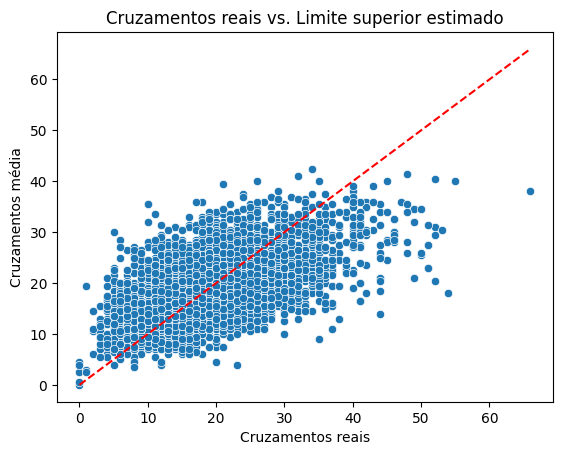

,media,Cruzamentos 1
media,1.000000,0.555809
Cruzamentos 1,0.555809,1.000000


In [ ]:
df['media'] = (df['cruzamento_e'] + df['cruzamento_c'])/2
sns.scatterplot(x='Cruzamentos 1', y='media', data=df)
plt.title("Cruzamentos reais vs. Limite superior estimado")
plt.xlabel("Cruzamentos reais")
plt.ylabel("Cruzamentos média")
plt.plot([0, df[['Cruzamentos 1', 'media']].max().max()],
         [0, df[['Cruzamentos 1', 'media']].max().max()],
         'r--')  # linha de referência
plt.show()
df[['media', 'Cruzamentos 1']].corr()

Conclusão Final: As correlações obtidas são fracas. A variabilidade nos cruzamentos (certos ou errados) continua alta mesmo considerando possíveis desdobramentos lógicos.

###Decisão Final

Devido à baixa correlação com outras variáveis e à alta variabilidade de resultados, conclui-se que a variável Cruzamentos não contribui de maneira significativa para a análise ou modelos preditivos, sendo, portanto, removida do dataset final.

###Conclusão

In [ ]:
df.drop(columns = ['Cruzamentos certos 1','Cruzamentos errados 1','Cruzamento total 1','% Chutes a gol por cruzamento',
    '% Chutes fora por cruzamento',
    '% Chutes bloqueados por cruzamento',
    '% Contra-ataques por cruzamento',
    '% Escanteios por cruzamento',
    '% Laterais por cruzamento',
    '% Tiros de meta por cruzamento','limite','limite_superior','limite_inferior','media','cruzamento_c','cruzamento_e'])

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,Cartões amarelos 1,Cartões amarelos 2,Cartões vermelhos 1,Cartões vermelhos 2,Cruzamentos 1,Cruzamentos 2,Laterais 1,Laterais 2,Chutes bloqueados 1,Chutes bloqueados 2,Contra-ataques 1,Contra-ataques 2,Gols 1,Gols 2,Tiro de meta 1,Tiro de meta 2,Tratamentos 1,Tratamentos 2,Substituições 1,Substituições 2,Tiros-livres 1,Tiros-livres 2,Defesas difíceis 1,Defesas difíceis 2,Posse 1(%),Posse 2(%),Time 1,Time 2,Position 1,Position 2
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,0.0,5.0,0.0,0.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,3.0,3.0,17.0,14.0,NaN,NaN,77.0,23.0,Glasgow Rangers,Livingston,4-3-3,4-3-3
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,4.0,1.0,0.0,0.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,2.0,3.0,16.0,19.0,NaN,NaN,44.0,56.0,Ross County,St.Johnstone,3-5-2,3-5-2
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,2.0,2.0,1.0,0.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,3.0,3.0,19.0,14.0,NaN,NaN,47.0,53.0,Dundee FC,St. Mirren,4-3-3,3-4-1-2
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,0.0,0.0,0.0,0.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,2.0,3.0,12.0,12.0,NaN,NaN,27.0,73.0,Hearts,Celtic,3-4-3,4-2-3-1
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,1.0,3.0,0.0,0.0,NaN,NaN,None,None,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,3.0,3.0,20.0,13.0,NaN,NaN,58.0,42.0,Aberdeen,Dundee U.,4-4-2,3-5-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27711,6.0,2.0,1.0,0.0,9.0,6.0,6.0,5.0,7.0,7.0,2.0,1.0,0.0,0.0,29.0,7.0,None,None,4.0,0.0,1.0,3.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,8.0,NaN,NaN,52.0,48.0,Aston Villa,Blackburn,4-4-2,4-5-1
27712,6.0,0.0,4.0,3.0,4.0,2.0,8.0,2.0,11.0,9.0,2.0,2.0,0.0,0.0,7.0,4.0,None,None,3.0,1.0,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,15.0,NaN,NaN,52.0,48.0,Arsenal,Fulham,4-2-3-1,4-4-2
27713,7.0,7.0,2.0,3.0,10.0,2.0,8.0,0.0,10.0,6.0,2.0,0.0,0.0,0.0,17.0,8.0,None,None,7.0,0.0,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,12.0,NaN,NaN,55.0,45.0,Manchester Utd,Stoke,4-4-2,4-4-2
27714,6.0,6.0,1.0,2.0,4.0,3.0,4.0,6.0,5.0,3.0,2.0,0.0,0.0,0.0,5.0,13.0,None,None,1.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,6.0,NaN,NaN,45.0,55.0,West Ham,Manchester City,4-5-1,4-4-2
